In [1]:
from ctypes import sizeof
from tabnanny import verbose
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.operators import PolynomialTensor
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from pyscf.lo import Boys
from pyscf.lo import PM
from qiskit_nature.units import DistanceUnit
import numpy as np  
from pyscf.tools import molden

/Users/arnab/arnab/workspace/.venv/lib/python3.9/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [2]:
dist_oh=0.96
angle_hoh=104.5

# Calculate H positions
theta = np.radians(angle_hoh / 2)
x = dist_oh * np.cos(theta)
y = dist_oh * np.sin(theta)
    
# Define H₂O geometry
atom = f"""O  0.0  0.0  0.0;H  {x:.3f}  {y:.3f}  0.0;H  {-x:.3f}  {y:.3f}  0.0"""
    
# Set up driver and problem
driver = PySCFDriver(
        atom=atom,
        basis="cc-pvdz",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM
)
problem = driver.run()
    
    


In [3]:
# Active space: O 2p (2,3,4) and H 1s (5,6)
transformer = ActiveSpaceTransformer(
        num_electrons=8,            # 4 (O 2p) + 2 (H 1s)
        num_spatial_orbitals=6,     # 3 (O 2p) + 2 (H 1s)
)
problem_reduced = transformer.transform(problem)
    
# Get Hamiltonian (already includes nuclear repulsion energy)
hamiltonian = problem_reduced.hamiltonian


In [4]:
fermionic_op = problem_reduced.hamiltonian.second_q_op()

In [5]:
mapper = JordanWignerMapper()
tapered_mapper = problem_reduced.get_tapered_mapper(mapper)

In [6]:
qubit_op = tapered_mapper.map(fermionic_op)
print(qubit_op)

SparsePauliOp(['IIIIIIII', 'ZIZIZIZZ', 'ZIIIZZII', 'IIZIIZZZ', 'ZIZIZXZZ', 'IIIIIXII', 'IIZIIXZZ', 'ZIIIZXII', 'IIIIIIIZ', 'ZIZIZIZI', 'IIZIIIYY', 'ZIIIZIXX', 'IIZIIIXX', 'ZIIIZIYY', 'IIZIIIII', 'ZIIIZIZZ', 'IIIIIIZI', 'ZIZIZIIZ', 'IIIIIZII', 'ZIZIZZZZ', 'ZZZZZIII', 'IZIZIIZZ', 'ZZZXIIII', 'IZIXZIZZ', 'IIIXZIII', 'ZIZXIIZZ', 'ZXIIIIII', 'IXZIZIZZ', 'IXZZZIII', 'ZXIZIIZZ', 'IIIIZIII', 'ZIZIIIZZ', 'YZZZYIII', 'XZIZXIZZ', 'XZZZXIII', 'YZIZYIZZ', 'IIIZIIII', 'ZIZZZIZZ', 'IYZYIIII', 'ZYIYZIZZ', 'IXZXIIII', 'ZXIXZIZZ', 'IZIIIIII', 'ZZZIZIZZ', 'ZIIIIIII', 'IIZIZIZZ', 'IIZIIZZX', 'ZIZIZIZX', 'ZIIIZZIX', 'IIIIIIIX', 'IIIIIZXI', 'ZIIIZIXI', 'ZIZIZZXZ', 'IIZIIIXZ', 'IIIIIXIX', 'IIIIIYIY', 'ZIIIZYIY', 'ZIZIZYZY', 'IIZIIYZY', 'IIZIIXZX', 'IIZIIXXZ', 'IIZIIYYZ', 'ZIZIZYYZ', 'ZIIIZYYI', 'IIIIIYYI', 'IIIIIXXI', 'ZZIZXZZZ', 'IIZIXZZZ', 'ZZZZXIII', 'IIIIXIII', 'XIZIIZZZ', 'XZIZZZZZ', 'XIIIIIII', 'XZZZZIII', 'IIZYYZZZ', 'IIZXXZZZ', 'IIIYYIII', 'IIIXXIII', 'IYIZYZZZ', 'IXIZXZZZ', 'IYZZYIII', 'IXZZXIII', '

In [7]:
np.save("qubit_op_h2o_tapered.npy", qubit_op)

In [8]:
eigenvalues, eigenvectors=np.linalg.eig(qubit_op.to_matrix())


In [9]:
print(np.min(eigenvalues))

(-23.96717906882319+0j)


In [10]:
ecore = problem_reduced.hamiltonian.constants
print("Core energy (ecore):", ecore)

Core energy (ecore): {'nuclear_repulsion_energy': 9.26852438683264, 'ActiveSpaceTransformer': -61.30982167608275}


In [11]:
# Define F2 geometry
atom = f"""F  0.0  0.0  0.0;F  1.42 0.0  0.0"""
    
# Set up driver and problem
driver = PySCFDriver(
        atom=atom,
        basis="cc-pvdz",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM
)
problem = driver.run()

In [12]:
# Active space
transformer = ActiveSpaceTransformer(
        num_electrons=10,           
        num_spatial_orbitals=6,     
)
problem_reduced = transformer.transform(problem)
    
# Get Hamiltonian (already includes nuclear repulsion energy)
hamiltonian = problem_reduced.hamiltonian

In [13]:
fermionic_op = problem_reduced.hamiltonian.second_q_op()
mapper = JordanWignerMapper()
tapered_mapper = problem_reduced.get_tapered_mapper(mapper)
qubit_op = tapered_mapper.map(fermionic_op)
print(qubit_op)

SparsePauliOp(['IIIIIIII', 'IZZZIZIZ', 'IIIIIIIZ', 'IZZZIZII', 'ZIIZIZII', 'ZZZIIIIZ', 'ZZZIIZZI', 'ZIIZIIZZ', 'ZIIZIIXZ', 'IZZZIZXZ', 'IIIIIIZI', 'IZZZIZZZ', 'IIIIIZII', 'IZZZIIIZ', 'ZZZZZIII', 'ZIIIZZIZ', 'IIIIZIII', 'IZZZZZIZ', 'IIIZIIII', 'IZZIIZIZ', 'IIZIIIII', 'IZIZIZIZ', 'IXXZIZIZ', 'IYYZIZIZ', 'IZIIIIII', 'IIZZIZIZ', 'ZIIIIIII', 'ZZZZIZIZ', 'ZIIZIIZX', 'ZZZIIZZX', 'ZIIZIIXX', 'IZZZIZXX', 'IZZZIZYY', 'ZZZIIZYY', 'ZZZIIZXX', 'IIIIIIXX', 'IZZZIZZX', 'IIIIIIZX', 'ZIIIXZIX', 'IZZZXZIX', 'ZZZZXIIX', 'IIIIXIIX', 'IZIZIZIX', 'IIZIIIIX', 'IXXZIZIX', 'IYYZIZIX', 'IYYIIIIX', 'IXXIIIIX', 'IIZZIZIX', 'IZIIIIIX', 'IIIIIXII', 'ZZZIIXZI', 'IZZZIXZI', 'IZZZIXIZ', 'ZZZIIXIZ', 'IIIIIXZZ', 'ZZZIIYYI', 'ZZZIIXXI', 'IZZZIXXI', 'ZIIZIYYZ', 'IIIIIYYZ', 'IIIIIXXZ', 'IIIXIIII', 'ZZZXZIII', 'ZZZXIIIZ', 'IIIXZIIZ', 'XIXIIIII', 'YIYIIIII', 'YZYIIIIZ', 'XZXIIIIZ', 'XXZIIIII', 'YYZIIIII', 'YYIIIIIZ', 'XXIIIIIZ', 'ZZXIIZZI', 'IIXZZZZI', 'IZXZIZIZ', 'ZIXIZZIZ', 'ZXIIIZZI', 'IXZZZZZI', 'IXIZIZIZ', 'ZXZIZZIZ', '

In [14]:
np.save("qubit_op_f2_tapered.npy", qubit_op)
eigenvalues, eigenvectors=np.linalg.eig(qubit_op.to_matrix())
print(np.min(eigenvalues))

(-33.10869285103632+0j)


In [15]:
ecore = problem_reduced.hamiltonian.constants
print("Core energy (ecore):", ecore)

Core energy (ecore): {'nuclear_repulsion_energy': 30.18546062290141, 'ActiveSpaceTransformer': -195.82280159016864}


In [16]:
# Define F2 geometry
atom = f"""N  0.0  0.0  0.0;N  1.10 0.0  0.0"""
    
# Set up driver and problem
driver = PySCFDriver(
        atom=atom,
        basis="cc-pvdz",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM
)
problem = driver.run()

In [17]:
# Active space
transformer = ActiveSpaceTransformer(
        num_electrons=6,           
        num_spatial_orbitals=6,     
)
problem_reduced = transformer.transform(problem)
    
# Get Hamiltonian (already includes nuclear repulsion energy)
hamiltonian = problem_reduced.hamiltonian

In [18]:
fermionic_op = problem_reduced.hamiltonian.second_q_op()
mapper = JordanWignerMapper()
tapered_mapper = problem_reduced.get_tapered_mapper(mapper)
qubit_op = tapered_mapper.map(fermionic_op)
print(qubit_op)

SparsePauliOp(['IIIIIIII', 'IZZZZZII', 'ZIIZZZIZ', 'ZZZIIIIZ', 'IIIIIIIZ', 'IZZZZZIZ', 'ZZZIIZZI', 'ZIIZZIZI', 'IIIIIIZI', 'IZZZZZZI', 'IIIIIZII', 'IZZZZIII', 'ZZZZZIII', 'ZIIIIZII', 'IIIIZIII', 'IZZZIZII', 'IIIZIIII', 'IZZIZZII', 'IIZIIIII', 'IZIZZZII', 'IZIIIIII', 'IIZZZZII', 'ZIIIIIII', 'ZZZZZZII', 'IIIIIXIZ', 'ZZZIIXZZ', 'IZZZZXZI', 'IZZZZXIZ', 'ZZZIIXII', 'IIIIIXZI', 'ZZZIIYYZ', 'ZZZIIXXZ', 'IZZZZXXI', 'ZIIZZYYZ', 'IIIIIYYI', 'IIIIIXXI', 'IIIZXIIZ', 'ZZZIXIIZ', 'ZZZZXIII', 'IIIIXIII', 'XIXIIIIZ', 'YIYIIIIZ', 'YZYIIIII', 'XZXIIIII', 'XXZIIIIZ', 'YYZIIIIZ', 'YYIIIIII', 'XXIIIIII', 'IIIIIXIX', 'ZZZIIXZX', 'ZZZIIYZY', 'IZZZZXIX', 'IZZZZYIY', 'ZIIZZYZY', 'ZZZIIYYX', 'ZZZIIXXX', 'ZZZIIYXY', 'ZIIZZYYX', 'ZIIZZXYY', 'ZIIZZYXY', 'IIIXIIIX', 'ZZZXZIIX', 'IZZYZZIY', 'ZIIYIZIY', 'XIXIIIIX', 'YIYIIIIX', 'XZYZZZIY', 'YZXZZZIY', 'XXZIIIIX', 'YYZIIIIX', 'XYIZZZIY', 'YXIZZZIY', 'ZZXIIZZI', 'IIXZZZZI', 'IZXZZZII', 'ZIXIIZII', 'YZZZYZZI', 'XZZZXZZI', 'XZZIXZII', 'YZZIYZII', 'YZZYIZZI', 'XZZXIZZI', '

In [19]:
np.save("qubit_op_N2_tapered.npy", qubit_op)
eigenvalues, eigenvectors=np.linalg.eig(qubit_op.to_matrix())
print(np.min(eigenvalues))

(-11.46451082357542+0j)


In [20]:
ecore = problem_reduced.hamiltonian.constants
print("Core energy (ecore):", ecore)

Core energy (ecore): {'nuclear_repulsion_energy': 23.572439395527272, 'ActiveSpaceTransformer': -121.1298335672692}


In [21]:
atom = f"""H  0.0  0.0  0.0;H  0.74 0.0  0.0;H 1.48 0.0  0.0;H 2.22 0.0  0.0;H 2.96 0.0  0.0;H 3.70 0.0  0.0"""
    
# Set up driver and problem
driver = PySCFDriver(
        atom=atom,
        basis="sto-3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM
)
problem = driver.run()
hamiltonian = problem.hamiltonian
fermionic_op = problem.hamiltonian.second_q_op()
mapper = JordanWignerMapper()
tapered_mapper = problem.get_tapered_mapper(mapper)
qubit_op = tapered_mapper.map(fermionic_op)
print(qubit_op)


SparsePauliOp(['IIIIIIIII', 'ZIZIZIZIZ', 'ZIZIZZIZI', 'IIIIIZZZZ', 'ZIZIZZIXZ', 'IIIIIZZXI', 'IIIIIIIXZ', 'ZIZIZIZXI', 'ZIZIZXZIZ', 'IIIIIXIII', 'IIIIIXZZZ', 'ZIZIZXIZI', 'IIIIIIIIZ', 'ZIZIZIZII', 'IIIIIIYZY', 'ZIZIZIXZX', 'IIIIIIXZX', 'ZIZIZIYZY', 'IIIIIIIZI', 'ZIZIZIZZZ', 'IIIIIYZYI', 'ZIZIZYIYZ', 'IIIIIXZXI', 'ZIZIZXIXZ', 'IIIIIIZII', 'ZIZIZIIIZ', 'IIIIIZIII', 'ZIZIZZZIZ', 'ZZZZZIIII', 'IZIZIIZIZ', 'ZZZXIIIII', 'IZIXZIZIZ', 'IIIXZIIII', 'ZIZXIIZIZ', 'ZXIIIIIII', 'IXZIZIZIZ', 'IXZZZIIII', 'ZXIZIIZIZ', 'IIIIZIIII', 'ZIZIIIZIZ', 'IIYZYIIII', 'ZIXZXIZIZ', 'IIXZXIIII', 'ZIYZYIZIZ', 'YZZZYIIII', 'XZIZXIZIZ', 'XZZZXIIII', 'YZIZYIZIZ', 'IIIZIIIII', 'ZIZZZIZIZ', 'IYZYIIIII', 'ZYIYZIZIZ', 'IXZXIIIII', 'ZXIXZIZIZ', 'IIZIIIIII', 'ZIIIZIZIZ', 'YZYIIIIII', 'XZXIZIZIZ', 'XZXIIIIII', 'YZYIZIZIZ', 'IZIIIIIII', 'ZZZIZIZIZ', 'ZIIIIIIII', 'IIZIZIZIZ', 'IIIIIZZZX', 'ZIZIZIZIX', 'ZIZIZZIZX', 'IIIIIIIIX', 'IIIIIZXII', 'ZIZIZIXZI', 'ZIZIZZXIZ', 'IIIIIIXZZ', 'IIIIIZZXX', 'IIIIIZZYY', 'ZIZIZIZYY', 'ZIZIZZIYY

In [22]:
np.save("qubit_op_H6_tapered.npy", qubit_op)
eigenvalues, eigenvectors=np.linalg.eig(qubit_op.to_matrix())
print(np.min(eigenvalues))

(-9.363773249019124+0j)


In [23]:
ecore = problem.hamiltonian.constants
print("Core energy (ecore):", ecore)

Core energy (ecore): {'nuclear_repulsion_energy': 6.221407750005406}


In [24]:
atom = f"""H  0.0  0.0  0.0;H 0.735 0.0  0.0"""
    
# Set up driver and problem
driver = PySCFDriver(
        atom=atom,
        basis="sto-3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM
)
problem = driver.run()
hamiltonian = problem.hamiltonian
fermionic_op = problem.hamiltonian.second_q_op()
mapper = JordanWignerMapper()
qubit_op = mapper.map(fermionic_op)
print(qubit_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.12091263+0.j,
  0.17218393+0.j,  0.16892754+0.j, -0.22575349+0.j,  0.16614543+0.j,
  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,
  0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j])


In [25]:
np.save("qubit_op_H2_sto3g_4qubit.npy", qubit_op)

In [30]:
energies=[]
for dist in np.arange(0.5, 3.05, 0.05):  # includes up to ~3.0
    atom = f"H  0.0  0.0  0.0; H  {dist:.2f} 0.0  0.0"
            
    # Set up driver and problem
    driver = PySCFDriver(
            atom=atom,
            basis="sto-3g",
            charge=0,
            spin=0,
            unit=DistanceUnit.ANGSTROM
    )
    problem = driver.run()
    hamiltonian = problem.hamiltonian
    hamiltonian.electronic_integrals.alpha += PolynomialTensor({"": problem.nuclear_repulsion_energy})
    hamiltonian.nuclear_repulsion_energy = None
    fermionic_op = problem.hamiltonian.second_q_op()
    mapper =ParityMapper(num_particles=problem.num_particles)
    qubit_op = mapper.map(fermionic_op)

    print(qubit_op)
    energy,eigvecs=np.linalg.eig(qubit_op)
    energies.append(energy)
    matrix = qubit_op.to_matrix()
    filename = f"H2_sto3g_{dist:.2f}.npy"
    np.save(filename, matrix)


SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[ 0.11064654+0.j,  0.58307963+0.j, -0.58307963+0.j, -0.01251643+0.j,
  0.16887023+0.j])
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-0.01837352+0.j,  0.53648878+0.j, -0.53648878+0.j, -0.01230035+0.j,
  0.17124452+0.j])
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-0.12516506+0.j,  0.49401379+0.j, -0.49401379+0.j, -0.01206439+0.j,
  0.17373064+0.j])
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-0.21393163+0.j,  0.45543342+0.j, -0.45543342+0.j, -0.01180192+0.j,
  0.17631845+0.j])
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-0.28794508+0.j,  0.42045568+0.j, -0.42045568+0.j, -0.0115074 +0.j,
  0.17900058+0.j])
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-0.34983342+0.j,  0.38874759+0.j, -0.38874759+0.j, -0.01117714+0.j,
  0.18177154+0.j])
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-0

In [31]:
print(energies)

[array([ 0.26700034+0.j, -0.07074011+0.j,  1.30148575+0.j, -1.05515979+0.j]), array([ 0.14057064+0.j, -0.20191839+0.j,  1.08048357+0.j, -1.09262991+0.j]), array([-0.31096009+0.j,  0.0365012 +0.j,  0.89008467+0.j, -1.11628601+0.j]), array([-0.402052  +0.j, -0.0494151 +0.j,  0.72564537+0.j, -1.12990478+0.j]), array([-0.1204519 +0.j, -0.47845306+0.j,  0.5833141 +0.j, -1.13618945+0.j]), array([-0.17923903+0.j, -0.5427821 +0.j,  0.45980452+0.j, -1.13711707+0.j]), array([-0.22792423+0.j, -0.5971778 +0.j,  0.35228457+0.j, -1.13414767+0.j]), array([-0.64339155+0.j, -0.26826785+0.j, -1.12836188+0.j,  0.25832675+0.j]), array([-0.301706  +0.j, -0.68284939+0.j,  0.17588132+0.j, -1.12056028+0.j]), array([-0.32940157+0.j, -0.71670221+0.j,  0.10324952+0.j, -1.11133942+0.j]), array([-0.74587179+0.j, -0.35229063+0.j, -1.10115033+0.j,  0.03904763+0.j]), array([-0.77109432+0.j, -0.37112578+0.j, -0.01783818+0.j, -1.09034218+0.j]), array([-0.38651524+0.j, -0.7929597 +0.j, -0.0683013 +0.j, -1.07919294+0.j])

In [32]:
import matplotlib.pyplot as plt

In [33]:
dist=0.64
atom = f"H  0.0  0.0  0.0; H  {dist:.2f} 0.0  0.0"
            
# Set up driver and problem
driver = PySCFDriver(
            atom=atom,
            basis="sto-3g",
            charge=0,
            spin=0,
            unit=DistanceUnit.ANGSTROM
    )
problem = driver.run()
hamiltonian = problem.hamiltonian
hamiltonian.electronic_integrals.alpha += PolynomialTensor({"": problem.nuclear_repulsion_energy})
hamiltonian.nuclear_repulsion_energy = None
fermionic_op = problem.hamiltonian.second_q_op()
mapper =ParityMapper(num_particles=problem.num_particles)
qubit_op = mapper.map(fermionic_op)

print(qubit_op)
energy,eigvecs=np.linalg.eig(qubit_op)
matrix = qubit_op.to_matrix()
filename = f"H2_sto3g_{dist:.2f}.npy"
np.save(filename, matrix)


SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-0.19745265+0.j,  0.46285119+0.j, -0.46285119+0.j, -0.01185683+0.j,
  0.17579314+0.j])


In [34]:
energies
type(energies)
len(energies)

51

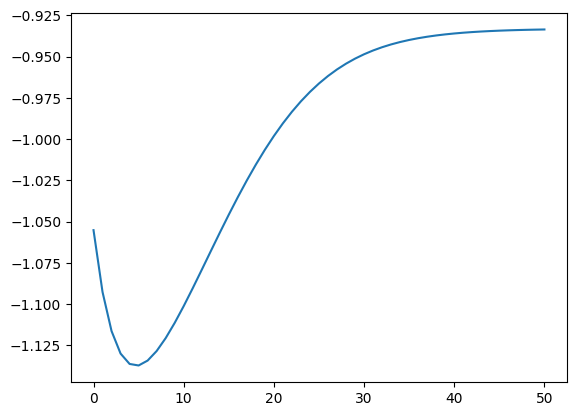

In [36]:
gs=[]
for i in range(51):
    gs.append(np.min(energies[i]))
plt.plot(gs)